### Importing all the libraries

In [54]:
import numpy as np
import time
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import heapq

### Loading the dataset

In [26]:
dataset = np.load('./data.npy', allow_pickle=True)
print(dataset.shape)
# 1500 samples
# each sample has 5 rows - # game_id , ResNet , Vit , label_name , guess_time

(1500, 5)


### Finding all the unique labels and creating a mapping

In [27]:
data_labels = dataset[:][:, 3].copy()
unique_data_labels = np.array(list(set(data_labels)))
print(f"There are {len(unique_data_labels)} unique labels")

data_label_to_idx = {label : idx + 1 for idx, label in enumerate(unique_data_labels)}
idx_to_data_label = {idx + 1 : label for idx, label in enumerate(unique_data_labels)}

There are 193 unique labels


### Bar graph showing the frequency of the datalabels in the dataset

<BarContainer object of 193 artists>

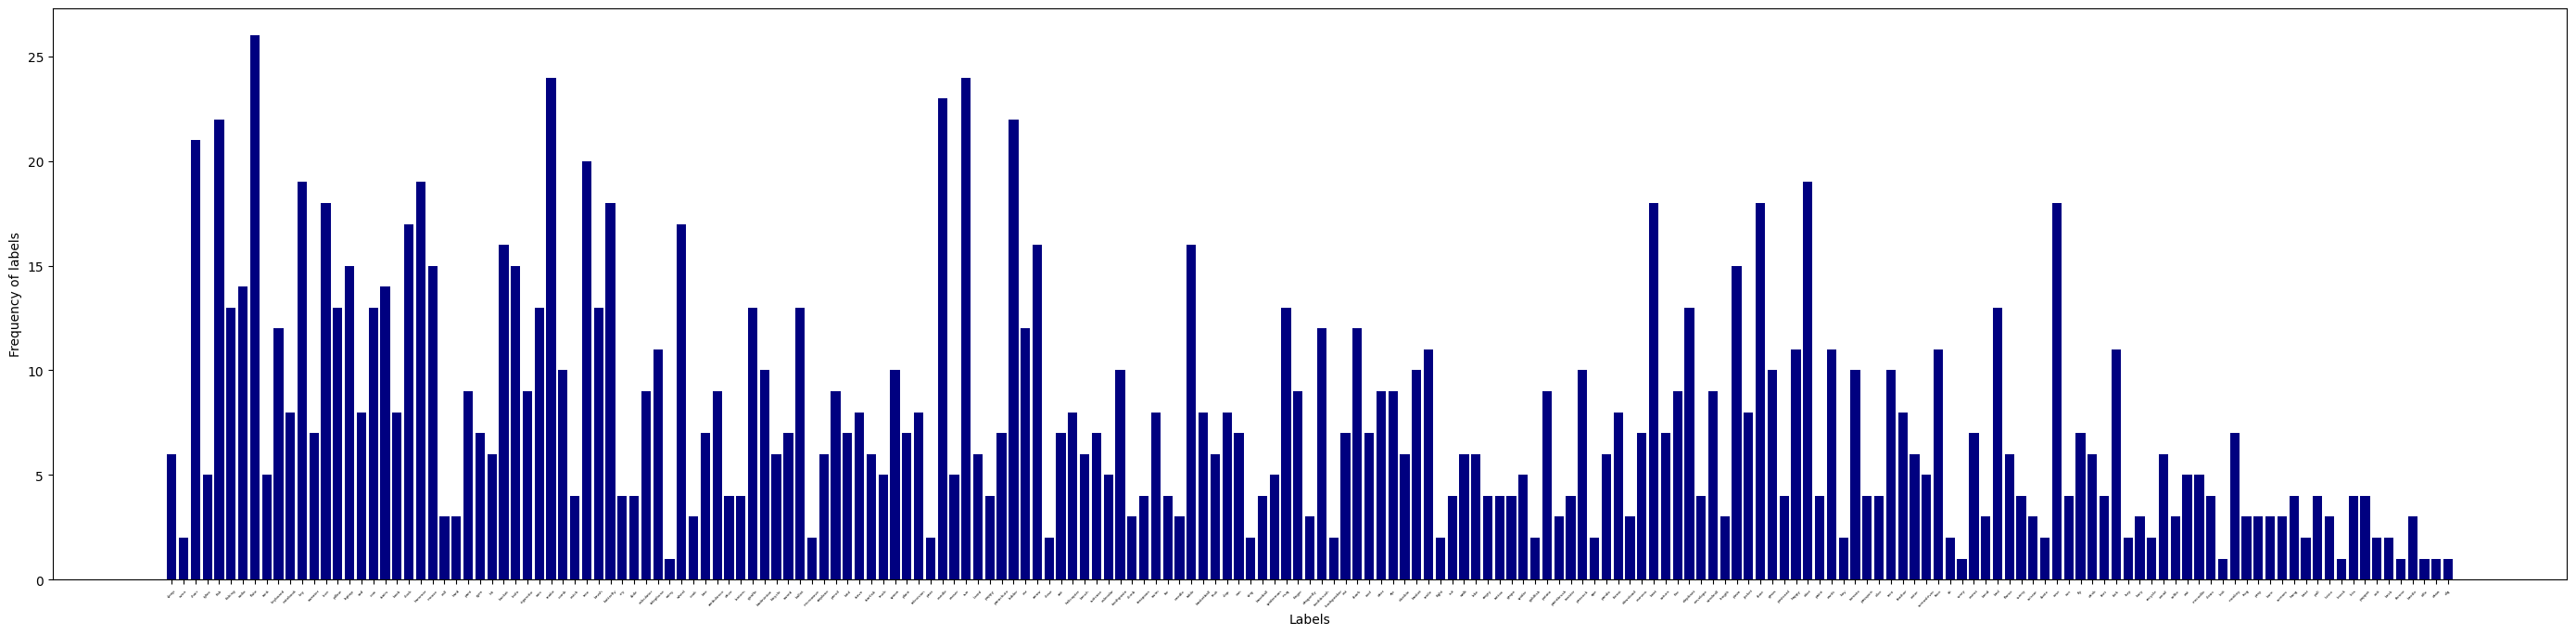

In [28]:
unique_labels_freq = Counter(data_labels)
plt.figure(figsize=(35, 8))
plt.xlabel("Labels")
plt.xticks(rotation=45, fontsize=3)
plt.ylabel("Frequency of labels")
plt.bar(unique_labels_freq.keys(), unique_labels_freq.values(), color='navy')

In [44]:
# getting labels with a count > 10
imp_labels = [label for label in unique_labels_freq.keys() if unique_labels_freq[label] > 10]
print(f"Lables with frequency > 10: {len(imp_labels)}")
print(imp_labels)
print()

# finding mean and standard deviation of the labels count
mean = np.mean(list(unique_labels_freq.values()))
std = np.std(list(unique_labels_freq.values()))

print(f"Mean: {mean:0.3} | Std: {std:0.3}")

Lables with frequency > 10: 47
['chair', 'fish', 'fishing', 'radio', 'flute', 'keyboard', 'key', 'love', 'pillow', 'laptop', 'cow', 'stairs', 'clock', 'hammer', 'mouse', 'bucket', 'knife', 'rain', 'snake', 'tree', 'brush', 'butterfly', 'telephone', 'wheel', 'giraffe', 'bullet', 'candle', 'sun', 'ladder', 'car', 'arrow', 'table', 'mug', 'toothbrush', 'shark', 'smile', 'boat', 'elephant', 'pizza', 'shoe', 'happy', 'door', 'earth', 'face', 'bed', 'rose', 'fork']

Mean: 7.77 | Std: 5.45


### Storing the resnet and vit embeddings in separate np arrays and reshaping for simplicity

In [30]:
X_resnet = dataset[:][:, 1].copy()
X_vit = dataset[:][:, 2].copy()
X_resnet = [arr.squeeze() for arr in X_resnet]
X_vit = [arr.squeeze() for arr in X_vit]

X_resnet = np.array(X_resnet)
X_vit = np.array(X_vit)
y = np.array([data_label_to_idx[label] for label in data_labels])
print(X_resnet.shape)
print(y.shape)

(1500, 1024)
(1500,)


## KNN Class

In [31]:
class KNN:
    def __init__(self, k=3, distance_metric='euclidean'):
        self.k = k
        self.distance_metric = distance_metric

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def distance(self, x1, x2):
        if self.distance_metric == 'euclidean':
            return np.sqrt(np.sum((x1 - x2)**2))
        elif self.distance_metric == 'manhattan':
            return np.sum(np.abs(x1 - x2))
        elif self.distance_metric == 'cosine':
            return 1 - np.dot(x1, x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        distances = [self.distance(x, x_train) for x_train in self.X_train] # find distances from all training samples
        k_indices = np.argsort(distances)[:self.k] # find indices of k nearest neighbors
        k_nearest_labels = [self.y_train[i] for i in k_indices] # get labels of k nearest neighbors (KNNs)
        most_common = Counter(k_nearest_labels).most_common(1) # find most common label among KNNs
        return most_common[0][0]

    def evaluate(self, X_val, y_val):
        y_pred = self.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='macro')
        acc = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred, average='macro', zero_division=1)
        recall = recall_score(y_val, y_pred, average='macro', zero_division=1)
                
        return {"F1 Score": f1, "Accuracy": acc, "Precision": precision, "Recall": recall}

### Trying out our KNN class for 1 example

In [32]:
X_train, X_val, y_train, y_val = train_test_split(X_resnet, y, test_size=0.2, random_state=42)

# Initialize and fit KNN classifier
knn = KNN(k=2, distance_metric='manhattan')
knn.fit(X_train, y_train)

# Predict and evaluate on validation set
result = knn.evaluate(X_val, y_val)
print("Model Metrics:", result)

Model Metrics: {'F1 Score': 0.11825683417269417, 'Accuracy': 0.18666666666666668, 'Precision': 0.40510849909584085, 'Recall': 0.2969359051637533}


### Splitting the dataset into train and test splits for ResNet and vit

In [33]:
X_resnet_train, X_resnet_val, y_resnet_train, y_resnet_val = train_test_split(X_resnet, y, test_size=0.2, random_state=42)
X_vit_train, X_vit_val, y_vit_train, y_vit_val = train_test_split(X_vit, y, test_size=0.2, random_state=42)

print(X_resnet_train.shape, X_resnet_val.shape, y_resnet_train.shape, y_resnet_val.shape)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(1200, 1024) (300, 1024) (1200,) (300,)
(1200, 1024) (300, 1024) (1200,) (300,)


### Creating a priority queue (max heap) for storing the best runs (highest accuracy) in descending order

In [34]:
# The code for this priority queue class was taken from chatgpt
class PriorityQueue: # max heap
    def __init__(self):
        self.heap = []
        self.counter = 0  # Counter to maintain order for items with the same priority
    
    def push(self, item):
        priority = (-item['Accuracy'], self.counter)
        heapq.heappush(self.heap, (priority, item))
        self.counter += 1
    
    def pop(self):
        if self.heap:
            return heapq.heappop(self.heap)[1]
        else:
            raise IndexError("pop from an empty max priority queue")
    
    def __len__(self):
        return len(self.heap)

In [35]:
datasets = ['resnet', 'vit']
distance_metrics = ['euclidean', 'manhattan', 'cosine']
best_results = PriorityQueue()

### Hyperparameter Tuning: Running the KNN for both embeddings and all distance metrics and various k values

In [48]:
for i in range(2): # looping on datasets
    print(f"Evaluating for {datasets[i]}")
    for j in range(3): # looping on distance metrics
        print(f"Using {distance_metrics[j]} distance")
        for k in range(1, 39): # looping on k
            knn = KNN(k=k, distance_metric=distance_metrics[j])
            if(datasets[i] == 'resnet'):
                knn.fit(X_resnet_train, y_resnet_train)
            else:
                knn.fit(X_vit_train, y_vit_train)

            # Predict and evaluate on validation set
            result = {}
            if(datasets[i] == 'resnet'):
                result = knn.evaluate(X_resnet_val, y_resnet_val)
            else:
                result = knn.evaluate(X_vit_val, y_vit_val)
            
            accuracy = result['Accuracy']
            f1 = result['F1 Score']
            precision = result['Precision']
            recall = result['Recall']
            
            best_results.push({'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'Dataset': datasets[i], 'Distance Metric': distance_metrics[j], 'K value': k})

            print(f"k: {k} | F1: {f1:0.2} | Precision: {precision:0.2} | Accuracy: {accuracy:0.2} | Recall: {recall:0.2}")
        print()
    print()
    print()

Evaluating for resnet
Using euclidean distance
k: 1 | F1: 0.11 | Precision: 0.41 | Accuracy: 0.19 | Recall: 0.3
k: 2 | F1: 0.11 | Precision: 0.41 | Accuracy: 0.19 | Recall: 0.3
k: 3 | F1: 0.11 | Precision: 0.41 | Accuracy: 0.2 | Recall: 0.29
k: 4 | F1: 0.1 | Precision: 0.41 | Accuracy: 0.19 | Recall: 0.29
k: 5 | F1: 0.11 | Precision: 0.43 | Accuracy: 0.2 | Recall: 0.29
k: 6 | F1: 0.11 | Precision: 0.44 | Accuracy: 0.21 | Recall: 0.29
k: 7 | F1: 0.11 | Precision: 0.46 | Accuracy: 0.2 | Recall: 0.26
k: 8 | F1: 0.1 | Precision: 0.46 | Accuracy: 0.19 | Recall: 0.25
k: 9 | F1: 0.095 | Precision: 0.48 | Accuracy: 0.18 | Recall: 0.25
k: 10 | F1: 0.1 | Precision: 0.5 | Accuracy: 0.2 | Recall: 0.24
k: 11 | F1: 0.11 | Precision: 0.51 | Accuracy: 0.2 | Recall: 0.24
k: 12 | F1: 0.11 | Precision: 0.52 | Accuracy: 0.19 | Recall: 0.23
k: 13 | F1: 0.11 | Precision: 0.53 | Accuracy: 0.2 | Recall: 0.23
k: 14 | F1: 0.1 | Precision: 0.52 | Accuracy: 0.2 | Recall: 0.23
k: 15 | F1: 0.1 | Precision: 0.53 | A

In [49]:
top20 = 20
while top20 > 0 and len(best_results):
    item = best_results.pop()
    top20 -= 1
    accuracy = item['Accuracy']
    precision = item['Precision']
    recall = item['Recall']
    f1 = item['F1 Score']
    distance = item['Distance Metric']
    k = item['K value']
    dataset = item['Dataset']
    
    print(f"Accuracy: {accuracy:0.2} | Precision: {precision:0.2} | Recall: {recall:0.2} | F1: {f1:0.2} | Distance: {distance} | Dataset: {dataset} | K: {k}")

Accuracy: 0.3 | Precision: 0.5 | Recall: 0.35 | F1: 0.18 | Distance: manhattan | Dataset: vit | K: 12
Accuracy: 0.3 | Precision: 0.54 | Recall: 0.35 | F1: 0.18 | Distance: manhattan | Dataset: vit | K: 13
Accuracy: 0.29 | Precision: 0.46 | Recall: 0.37 | F1: 0.17 | Distance: manhattan | Dataset: vit | K: 4
Accuracy: 0.29 | Precision: 0.53 | Recall: 0.34 | F1: 0.17 | Distance: manhattan | Dataset: vit | K: 14
Accuracy: 0.28 | Precision: 0.45 | Recall: 0.37 | F1: 0.17 | Distance: manhattan | Dataset: vit | K: 3
Accuracy: 0.28 | Precision: 0.48 | Recall: 0.35 | F1: 0.16 | Distance: manhattan | Dataset: vit | K: 10
Accuracy: 0.28 | Precision: 0.49 | Recall: 0.34 | F1: 0.16 | Distance: manhattan | Dataset: vit | K: 11
Accuracy: 0.28 | Precision: 0.44 | Recall: 0.36 | F1: 0.16 | Distance: manhattan | Dataset: vit | K: 1
Accuracy: 0.28 | Precision: 0.44 | Recall: 0.36 | F1: 0.16 | Distance: manhattan | Dataset: vit | K: 2
Accuracy: 0.27 | Precision: 0.48 | Recall: 0.34 | F1: 0.16 | Distance: 

### Plotting the accuracy vs k graph for ViT embeddings and euclidean distance for k = 1 to k = 30

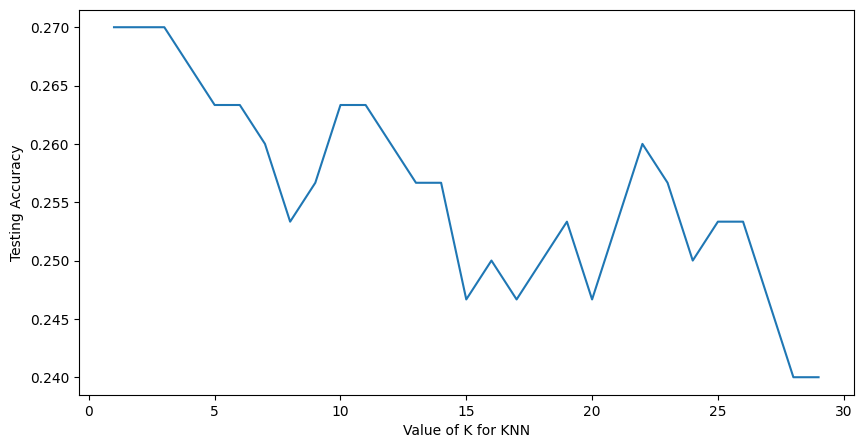

In [47]:
k_range = np.arange(1, 30)
accuracies = []
for k in range(1, 30):
    knn = KNN(k=k, distance_metric='euclidean')
    knn.fit(X_vit_train, y_vit_train)

    # Predict and evaluate on validation set
    result = knn.evaluate(X_vit_val, y_vit_val)
    accuracies.append(result['Accuracy'])
    # print(f"k: {k} | Accuracy: {result['Accuracy']:0.2} | F1: {result['F1 Score']:0.2} | Precision: {result['Precision']:0.2} | Recall: {result['Recall']:0.2}")

plt.figure(figsize=(10, 5))
plt.plot(k_range, accuracies)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.show()

Best Model time: 1.84 | Sklearn Model time: 0.146


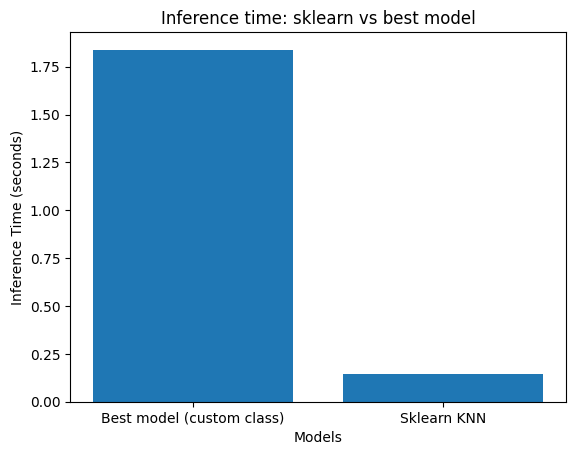

In [66]:
X_vit_train, X_vit_val, y_vit_train, y_vit_val = train_test_split(X_vit, y, test_size=0.2, random_state=42)

time_best_model = 0
time_sklearn_model = 0

knn = KNN(k=12, distance_metric='manhattan')
knn.fit(X_vit_train, y_vit_train)

start = time.time()
result = knn.evaluate(X_vit_val, y_vit_val)
end = time.time()

time_best_model = end - start

sklearn_model = KNeighborsClassifier(n_neighbors=12, metric='manhattan')
sklearn_model.fit(X_vit_train, y_vit_train)

start = time.time()
sklearn_model.predict(X_vit_val)
end = time.time()

time_sklearn_model = end - start

print(f"Best Model time: {time_best_model:0.3} | Sklearn Model time: {time_sklearn_model:0.3}")

fig, ax = plt.subplots(1, 1)

ax.set_title("Inference time: sklearn vs best model")
ax.set_ylabel("Inference Time (seconds)")
ax.set_xlabel("Models")

ax.bar(["Best model (custom class)", "Sklearn KNN"], [time_best_model, time_sklearn_model])

plt.show()

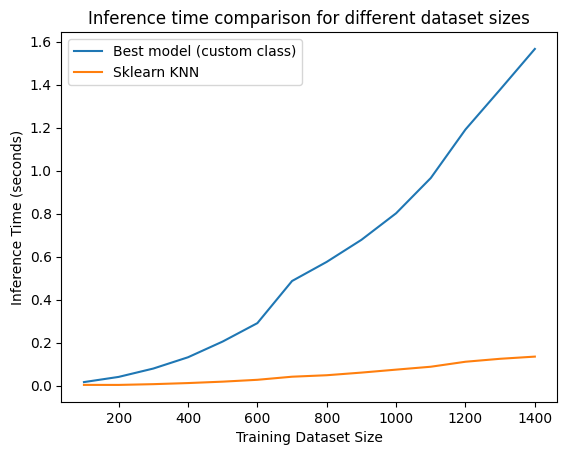

In [68]:
train_dataset_sizes = [size for size in range(100, X_vit.shape[0], 100)]

# Compare time for custom KNN model and sklearn knn model
time_best_model = []
time_sklearn_model = []

for size in train_dataset_sizes:
    X_vit_train_new, X_vit_val_new, y_vit_train_new, y_vit_val_new = train_test_split(X_vit[:size], y[:size], test_size=0.2, random_state=42)

    knn = KNN(k=12, distance_metric='manhattan')
    knn.fit(X_vit_train_new, y_vit_train_new)

    start = time.time()
    result = knn.evaluate(X_vit_val_new, y_vit_val_new)
    end = time.time()

    time_best_model.append(end - start)

    sklearn_model = KNeighborsClassifier(n_neighbors=12, metric='manhattan')
    sklearn_model.fit(X_vit_train_new, y_vit_train_new)

    start = time.time()
    sklearn_model.predict(X_vit_val_new)
    end = time.time()

    time_sklearn_model.append(end - start)

fig, ax = plt.subplots(1, 1)

ax.set_title("Inference time comparison for different dataset sizes")
ax.set_ylabel("Inference Time (seconds)")
ax.set_xlabel("Training Dataset Size")

ax.plot(train_dataset_sizes, time_best_model, label="Best model (custom class)")
ax.plot(train_dataset_sizes, time_sklearn_model, label="Sklearn KNN")
ax.legend()
plt.show()